In [81]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

import requests
from IPython.display import Image

In [82]:
# Load the data as a NumPy array
data = np.loadtxt('usincmoms.txt')

PART A: HISTOGRAM

<IPython.core.display.Javascript object>


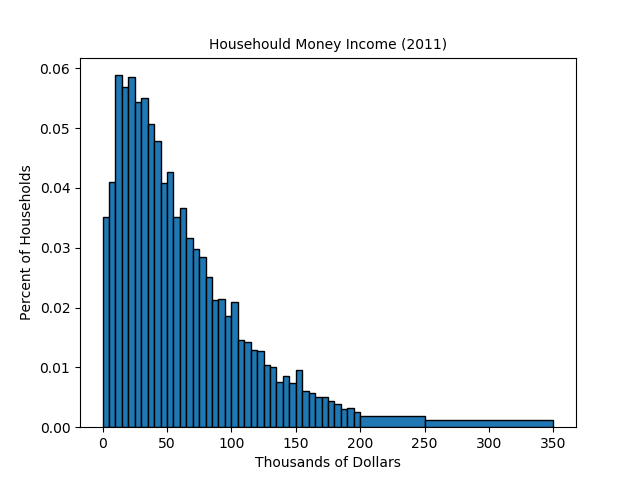

In [83]:
#Part (a): Plotting the Histogram
%matplotlib notebook

frequencies = data[:,0]
mid_point = data[:,1]

heights = np.copy(frequencies)
heights[40]=heights[40]/10
heights[41]=heights[41]/20

widths = 5 * np.ones(42)
widths[40] = 50
widths[41] = 100

bins = np.zeros((43,), dtype=int)
for x in range(1, 43):
    bins[0]=0
    bins[x]=bins[x-1]+(mid_point[x-1]-bins[x-1])*2

bins_g=bins/1000

plt.bar(bins_g[:-1], height=heights, width=widths, align='edge', edgecolor='k')
plt.title('Househould Money Income (2011)', fontsize=10)
plt.xlabel(r'Thousands of Dollars')
plt.ylabel(r'Percent of Households')
plt.show()

PART B: LN DISTRIBUTION

In [84]:
#Part b: GMM estimation of a LN distribution

#we get the model moments making use of the CDF of a lognormal that Python has
def model_moments_LN(mu, sigma):

    cdf_LN = lambda x: sts.lognorm.cdf(x, s = sigma, scale = np.exp(mu))
    moms_model = []
    
    for i in range(42):
        moms_model.append(cdf_LN(bins[i + 1]) - cdf_LN(bins[i]))
 
    moms_model[41] = 1 - cdf_LN(bins[41])
    
    return moms_model

#We define the vector error. Note that moms_data (momentos of the data) corresponds to the first column
#of the data in the txt file (I will pass this as an argument)
def err_vec_LN(data, mu, sigma, simple):

    moms_data = data
    moms_model = model_moments_LN(mu, sigma)
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

#We define the criterion function
def criterion_LN(params, *args):

    mu, sigma = params
    data, W = args
    
    err = err_vec_LN(data, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [85]:
# GMM estimation
mu_init = 11.1516255566386 #log of the avarage income. I have taken the avarage income of $69,677 given in the table 1 of PS3
sig_init = 10
params_init = np.array([mu_init, sig_init])

W_hat = np.eye(42)
W_hat = W_hat * frequencies

gmm_args = (frequencies, W_hat)


results_GMM = opt.minimize(criterion_LN, params_init, args = (gmm_args),
                       method = 'L-BFGS-B', bounds = ((None, None), (1e-10, None)))

mu_GMM, sig_GMM = results_GMM.x

print('mu_GMM =', mu_GMM) 
print('sig_GMM =', sig_GMM)
print('Criterion Function =', results_GMM.fun)


mu_GMM = 10.766844030696415
sig_GMM = 0.9078412043738691
Criterion Function = 0.04594528252834601


<IPython.core.display.Javascript object>


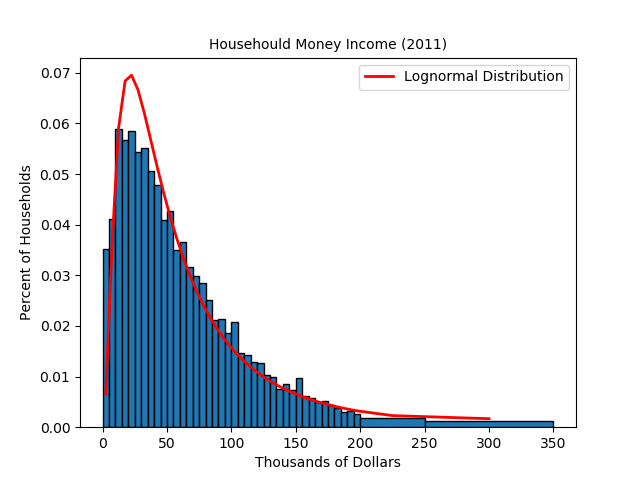

In [86]:
%matplotlib notebook

plt.bar(bins_g[:-1], height=heights, width=widths, align='edge', edgecolor='k')
plt.title('Househould Money Income (2011)', fontsize=10)
plt.xlabel(r'Thousands of Dollars')
plt.ylabel(r'Percent of Households')

moms_model = model_moments_LN(mu_GMM, sig_GMM)
moms_model[40] = moms_model[40] / 10
moms_model[41] = moms_model[41] / 20

#For the graph of the LN distribution we need to give as input the midpoint of the bin in the same scale of the histogram
mid_point_adj=mid_point/1000

plt.plot(mid_point_adj, moms_model, linewidth = 2, color = 'r', label = r'Lognormal Distribution')
plt.legend(loc='upper right')


PART C: GA DISTRIBUTION

In [91]:
#Part c: GMM estimation of a GA distribution

#we get the model moments making use of the CDF of a lognormal that Python has
def model_moments_GA(alpha, beta):

    cdf_GA = lambda x: sts.gamma.cdf(x, alpha, loc = 0, scale = beta)
    moms_model = []
    
    for i in range(42):
        moms_model.append(cdf_GA(bins[i + 1]) - cdf_GA(bins[i]))
 
    moms_model[41] = 1 - cdf_GA(bins[41])
    
    return moms_model

#We define the vector error. Note that moms_data (momentos of the data) corresponds to the first column
#of the data in the txt file (I will pass this as an argument)
def err_vec_GA(data, alpha, beta, simple):

    moms_data = data
    moms_model = model_moments_GA(alpha, beta)
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

#We define the criterion function
def criterion_GA(params, *args):

    alpha, beta = params
    data, W = args
    
    err = err_vec_GA(data, alpha, beta, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [92]:
# GMM estimation
alpha_init = 3 
beta_init = 20000
params_init = np.array([alpha_init, beta_init])

W_hat = np.eye(42)
W_hat = W_hat * frequencies

gmm_args = (frequencies, W_hat)


results_GMM_GA = opt.minimize(criterion_GA, params_init, args = (gmm_args),
                       method = 'L-BFGS-B', bounds = ((1e-10, None), (1e-10, None)))

alpha_GMM, beta_GMM = results_GMM_GA.x

print('alpha_GMM =', alpha_GMM) 
print('beta_GMM =', beta_GMM)
print('Criterion Function =', results_GMM_GA.fun)

alpha_GMM = 1.3612053899394279
beta_GMM = 48395.56983034368
Criterion Function = 0.012343191414737019


<IPython.core.display.Javascript object>


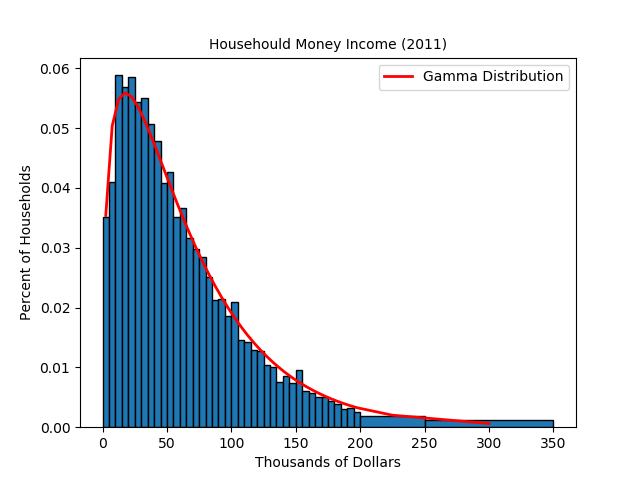

In [93]:
%matplotlib notebook

plt.bar(bins_g[:-1], height=heights, width=widths, align='edge', edgecolor='k')
plt.title('Househould Money Income (2011)', fontsize=10)
plt.xlabel(r'Thousands of Dollars')
plt.ylabel(r'Percent of Households')

moms_model = model_moments_GA(alpha_GMM, beta_GMM)
moms_model[40] = moms_model[40] / 10
moms_model[41] = moms_model[41] / 20

#For the graph of the LN distribution we need to give as input the midpoint of the bin in the same scale of the histogram
mid_point_adj=mid_point/1000

plt.plot(mid_point_adj, moms_model, linewidth = 2, color = 'r', label = r'Gamma Distribution')
plt.legend(loc='upper right')

PART D: COMBINING GRAPHS

<IPython.core.display.Javascript object>


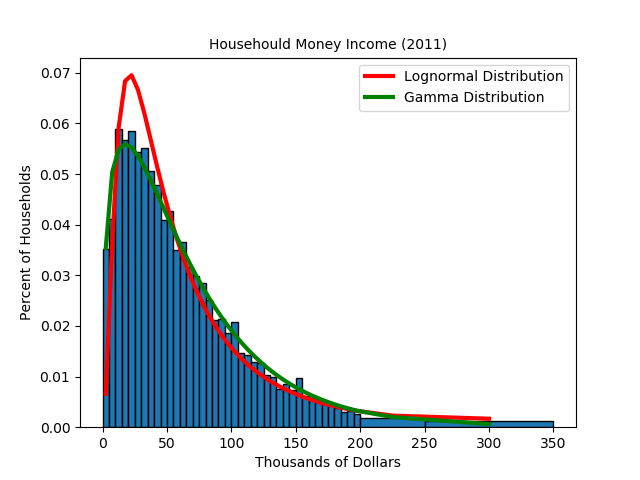

In [105]:
%matplotlib notebook

plt.bar(bins_g[:-1], height=heights, width=widths, align='edge', edgecolor='k')
plt.title('Househould Money Income (2011)', fontsize=10)
plt.xlabel(r'Thousands of Dollars')
plt.ylabel(r'Percent of Households')

moms_model = model_moments_LN(mu_GMM, sig_GMM)
moms_model[40] = moms_model[40] / 10
moms_model[41] = moms_model[41] / 20

#For the graph of the LN distribution we need to give as input the midpoint of the bin in the same scale of the histogram
mid_point_adj=mid_point/1000

plt.plot(mid_point_adj, moms_model, linewidth = 3, color = 'r', label = r'Lognormal Distribution')
plt.legend(loc='upper right')

moms_model = model_moments_GA(alpha_GMM, beta_GMM)
moms_model[40] = moms_model[40] / 10
moms_model[41] = moms_model[41] / 20

#For the graph of the LN distribution we need to give as input the midpoint of the bin in the same scale of the histogram
mid_point_adj=mid_point/1000

plt.plot(mid_point_adj, moms_model, linewidth = 3, color = 'g', label = r'Gamma Distribution')
plt.legend(loc='upper right')

In [106]:
#If we want to compare the fit of both distributions to the data, we can compare the minimized criterion function
#for both cases and see which ones is the lowest.

print('Criterion Function for the LN distribution =', results_GMM.fun)
print('Criterion Function for the GA distribution=', results_GMM_GA.fun)

Criterion Function for the LN distribution = 0.04594528252834601
Criterion Function for the GA distribution= 0.012343191414737019
